<a href="https://colab.research.google.com/github/gongx030/seatac_manuscript/blob/main/notebooks/K562_vs_GM12878.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examine the histone code changes between differential V-plots

## Background

Reviewer #1's Issue #2: Further, as SeATAC appears to be unique in documenting decreased chromatin accessibility at promoters of regulated genes, this aspect would be particularly interesting to biologists and browser views would be very helpful to convince the readers. To be really helpful, these browser views should include other typical marks of promoters and enhancers such as H3K4me3, H3K4me1, H3K27ac, etc.

## Tasks

* Train SeATAC model on GM12878, K562. 
* Find the differential V-plots and associated histone codes.
* Generate some browser views of differential V-plots

## Setup

### MSI Parition

```salloc --nodes=1 --ntasks-per-node=16 --mem=64gb -t 24:00:00 -p interactive```

### Conda

```r421_py37_tf26```

### Install R packages

In [ ]:
required_packages <- c(
  'BiocManager', 'devtools', 'Matrix',
  'dplyr', 'tidyr', 'stringr',
  'pROC', 'irlba',
  'chromVAR', 'chromVARmotifs', 'motifmatchr',
  'ChIPseeker'
)

In [ ]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [ ]:
for (p in required_packages){
  library(p, character.only  = TRUE)
}

ChIPseeker v1.32.1  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383



### Install SeATAC from github

In [ ]:
#devtools::install('../seatac')
#install_github('gongx030/seatac@v0.4.0', force = TRUE, quiet = FALSE)

In [ ]:
#reload(pkgload::inst("seatac"))
#library(seatac)

In [ ]:
devtools::load_all('../seatac')

ℹ Loading seatac
Loading required package: tensorflow

Warning message:
“package ‘tensorflow’ was built under R version 4.2.2”
Loading required package: tfprobability

Loading required package: tfdatasets

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:pROC’:

    var


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tappl

### Load bpt

In [ ]:
devtools::load_all('../bpt')

ℹ Loading bpt
Warning message:
“replacing previous import ‘GenomicRanges::union’ by ‘dplyr::union’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::intersect’ by ‘dplyr::intersect’ when loading ‘bpt’”
Warning message:
“replacing previous import ‘GenomicRanges::setdiff’ by ‘dplyr::setdiff’ when loading ‘bpt’”


## Parameters

In [ ]:
set.seed(123)

In [ ]:
ARGS <- list(

  remote_bam_files = c(
    'GM12878' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam',
    'K562' = 'https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.bam'
  ), 
  genome_version = 'hg19',
  remote_bw_files = list(
    'GM12878' = c(
      'H3K27ac' = 'https://www.encodeproject.org/files/ENCFF440GZA/@@download/ENCFF440GZA.bigWig',
      'H3K4me1' = 'https://www.encodeproject.org/files/ENCFF372EXQ/@@download/ENCFF372EXQ.bigWig',
      'H3K4me3' = 'https://www.encodeproject.org/files/ENCFF154XCY/@@download/ENCFF154XCY.bigWig'
    ),
    'K562' = c(
      'H3K27ac' = 'https://www.encodeproject.org/files/ENCFF488FYZ/@@download/ENCFF488FYZ.bigWig',
      'H3K4me1' = 'https://www.encodeproject.org/files/ENCFF700ZWZ/@@download/ENCFF700ZWZ.bigWig',
      'H3K4me3' = 'https://www.encodeproject.org/files/ENCFF285EUA/@@download/ENCFF285EUA.bigWig'
    )
  ),
  max_peaks_count_reads = 10000L,
  min_reads_train_seatac = 5L,
  block_size = 640L,
  latent_dim = 10L,
  min_reads_train = 5L,
  max_reads_train = 100L,
  step_size = 200L,
  fragment_size_range_max = 640L,
  bin_size = 5L,
  fragment_size_interval = 10L,
  window_size = 2000L,
  sliding_step = 10L,
  min_peaks = 1000L,
  max_peaks = 10000L, # maximum peaks to read
  batch_size = 256L,
  epochs = 100L,
  center_width = 100L, # the center width
  min_counts = 1L
)

In [ ]:
ARGS$local_bam_files <- gsub('https://', './', ARGS$remote_bam_files)

In [ ]:
ARGS$remote_summit_files <- gsub('.bam', '_summits.bed', ARGS$remote_bam_files)
ARGS$local_summit_files <- gsub('https://', './', ARGS$remote_summit_files)

In [ ]:
ARGS$local_bw_files <- list()
for (i in names(ARGS$remote_bw_files)){
  for (j in names(ARGS$remote_bw_files[[i]])){
    ARGS$local_bw_files[[i]][j] <- gsub('https://', './', ARGS$remote_bw_files[[i]][j])
  }
  stopifnot(all(file.exists(ARGS$local_bw_files[[i]])))
}

In [ ]:
ARGS$remote_pileup_files <- gsub('.bam$', '_treat_pileup.bw', ARGS$remote_bam_files)
ARGS$local_pileup_files <- gsub('https://', './', ARGS$remote_pileup_files)

In [ ]:
ARGS$remote_nucleoatac_files <- gsub('.bam$', '.nucleoatac_signal.smooth.bw', ARGS$remote_bam_files)
ARGS$local_nucleoatac_files <- gsub('https://', './', ARGS$remote_nucleoatac_files)

## Download files

### BAM files

In [ ]:
download_remote_file(ARGS$remote_bam_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.bam



In [ ]:
stopifnot(all(file.exists(ARGS$local_bam_files)))

### Pileup files

In [ ]:
download_remote_file(ARGS$remote_pileup_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_treat_pileup.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562_treat_pileup.bw



In [ ]:
stopifnot(all(file.exists(ARGS$local_pileup_files)))

### Summit files

In [ ]:
download_remote_file(ARGS$remote_summit_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562_summits.bed



In [ ]:
stopifnot(file.exists(ARGS$local_summit_files))

### bigwig files

In [ ]:
for (i in names(ARGS$remote_bw_files)){
  download_remote_file(ARGS$remote_bw_files[[i]])
  stopifnot(all(file.exists(ARGS$local_bw_files[[i]])))
}

wget -cx https://www.encodeproject.org/files/ENCFF440GZA/@@download/ENCFF440GZA.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF372EXQ/@@download/ENCFF372EXQ.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF154XCY/@@download/ENCFF154XCY.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF488FYZ/@@download/ENCFF488FYZ.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF700ZWZ/@@download/ENCFF700ZWZ.bigWig

wget -cx https://www.encodeproject.org/files/ENCFF285EUA/@@download/ENCFF285EUA.bigWig



### NucleoATAC files

In [ ]:
download_remote_file(ARGS$remote_nucleoatac_files)

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.nucleoatac_signal.smooth.bw

wget -cx https://s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.nucleoatac_signal.smooth.bw



In [ ]:
stopifnot(file.exists(ARGS$local_nucleoatac_files))

## Read summits

In [ ]:
gr0 <- lapply(ARGS$local_summit_file, function(bed_file){
  sprintf('reading %s', bed_file) %>% message()
  peaks <- read.table(bed_file, header = FALSE, sep = '\t')
  peaks <- GRanges(seqnames = peaks[, 1], range = IRanges(start = peaks[, 2], end = peaks[, 3]))
  peaks <- resize(peaks, fix = 'center', width = ARGS$step_size)
  peaks
}) %>%
  GRangesList() %>%
  coverage() %>%
  IRanges::slice(lower = 1, rangesOnly = TRUE) %>%
  GRanges() %>%
  resize(fix = 'center', width = ARGS$window_size)
gr0 <- gr0[seqnames(gr0) %in% sprintf('chr%s', c(1:22, 'X'))]
seqlevels(gr0) <- seqlevels(seqinfo(get_bsgenome(ARGS$genome_version)))
seqinfo(gr0, pruning.mode = 'coarse') <- seqinfo(get_bsgenome(ARGS$genome_version))

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562_summits.bed

Loading required package: BSgenome.Mmusculus.UCSC.mm10

Loading required package: BSgenome

Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit


Loading required package: rtracklayer

Loading required package: BSgenome.Hsapiens.UCSC.hg19

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 1 out-of-bound range located on sequence chr17.
  Note that ranges located on a sequence whose length is unknown (NA) or
  on a circular sequence are not considered out-of-bound (use
  seqlengths() and isCircular() to get the lengths and circularity flags
  of the underlying sequences). You can use trim() to trim these ranges.
  See ?`t

In [ ]:
gr0 <- trim(gr0)

In [ ]:
gr <- slidingWindows(gr0, width = ARGS$block_size, step = ARGS$bin_size) %>% unlist()
sprintf('total blocks: %d', length(gr)) %>% message()
gr <- sample(gr, min(length(gr), ARGS$max_peaks_count_reads))
sprintf('total blocks for training: %d', length(gr)) %>% message()

total blocks: 70369410

total blocks for training: 10000



In [ ]:
counts <- count_reads(gr, ARGS$local_bam_files, genome = get_bsgenome(ARGS$genome_version),  fragment_size_range = c(0, ARGS$fragment_size_range_max))

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.bam



In [ ]:
valid <- rowSums(counts >= ARGS$min_reads_train_seatac) == ncol(counts)
sprintf('number of valid peaks for VaeModel(>=%d reads): %d', ARGS$min_reads_train_seatac, sum(valid)) %>% message()
gr <- gr[valid]

number of valid peaks for VaeModel(>=5 reads): 9365



In [ ]:
x <- read_vplot(
  gr,
  filenames = ARGS$local_bam_files, 
  genome = get_bsgenome(ARGS$genome_version),
  bin_size = ARGS$bin_size,
  fragment_size_range = c(0, ARGS$fragment_size_range_max),
  fragment_size_interval = ARGS$fragment_size_interval
)

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrMT, chr4_ctg9_hap1, chr6_apd_hap1, chr6_cox_hap2, chr6_dbb_hap3, chr6_mann_hap4, chr6_mcf_hap5, chr6_qbl_hap6, chr6_ssto_hap7, chr17_ctg5_hap1, chr1_gl000191_random, chr1_gl000192_random, chr4_gl000193_random, chr4_gl000194_random, chr7_gl000195_random, chr8_gl000196_random, chr8_gl000197_random, chr9_gl000198_random, chr9_gl000199_random, chr9_gl000200_random, chr9_gl000201_random, chr11_gl000202_random, chr17_gl000203_random, chr17_gl000204_random, chr17_gl000205_random, chr17_gl000206_random, chr18_gl000207_random, chr19_gl000208_random, chr19_gl000209_random, chr21_gl000210_random, chrUn_gl000211, chrUn_gl000212, chrUn_gl000213, chrUn_gl000214, chrUn_gl000215, chrUn_gl000216, chrUn_gl000217, chrUn_gl000218, chrUn_gl000219, chrUn_gl000220, chrUn

## Training SeATAC

In [ ]:
model <- VaeModel(x, latent_dim = ARGS$latent_dim)

In [ ]:
model <- model %>% fit(x, batch_size = ARGS$batch_size, epochs = ARGS$epochs, compile = TRUE)

epoch=     1/   100 | beta=1.000e+00 | loss= 6151.3406092 | loss_reconstruction= 6148.5335858 | loss_kl=    2.8069935

epoch=     2/   100 | beta=1.000e+00 | loss= 4497.7453085 | loss_reconstruction= 4495.4458140 | loss_kl=    2.2994728

epoch=     3/   100 | beta=1.000e+00 | loss= 2376.4234487 | loss_reconstruction= 2376.3255120 | loss_kl=    0.0979419

epoch=     4/   100 | beta=1.000e+00 | loss=  767.9559005 | loss_reconstruction=  767.9370216 | loss_kl=    0.0188828

epoch=     5/   100 | beta=1.000e+00 | loss=  407.2343041 | loss_reconstruction=  406.8654274 | loss_kl=    0.3688765

epoch=     6/   100 | beta=1.000e+00 | loss=  347.1219284 | loss_reconstruction=  346.2628397 | loss_kl=    0.8590877

epoch=     7/   100 | beta=1.000e+00 | loss=  321.2597945 | loss_reconstruction=  318.8727912 | loss_kl=    2.3870018

epoch=     8/   100 | beta=1.000e+00 | loss=  303.6528518 | loss_reconstruction=  300.1409821 | loss_kl=    3.5118694

epoch=     9/   100 | beta=1.000e+00 | loss=  29

## Find GATA2 and NFKB1 motifs binding sites. 

GATA2 are enriched in K562 and NFKB1 are enriched in GM12878, according to Figure 3 from [Buenrostro et al](https://pubmed.ncbi.nlm.nih.gov/26083756/) 

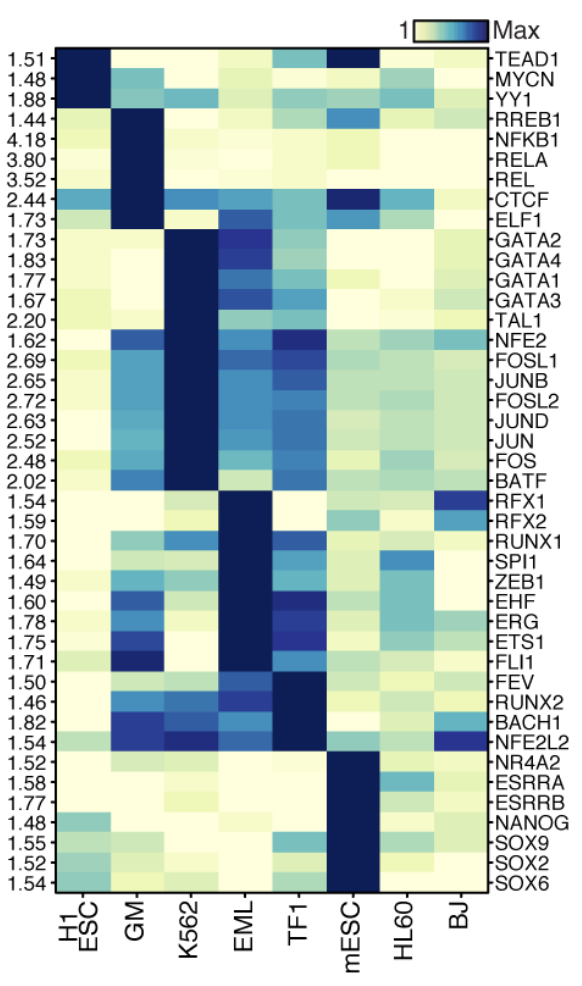

In [ ]:
data('homer_pwms')

### GATA2

In [ ]:
gata2 <- 102
homer_pwms[gata2]

PWMatrixList of length 1
names(1): Gata2(Zf)/K562-GATA2-ChIP-Seq(GSE18829)/Homer

In [ ]:
gr_gata2 <- matchMotifs(homer_pwms[gata2], gr0, genome = get_bsgenome(ARGS$genome_version), out = 'positions', p.cutoff = 5e-06)[[1]]  %>%
  resize(width = ARGS$block_size, fix = 'center')

In [ ]:
sprintf('number of GATA2-centric  regions: %s', length(gr_gata2)) %>% message()

number of GATA2-centric  regions: 10009



### NFKB1

In [ ]:
nfkb <- 208
homer_pwms[nfkb]

PWMatrixList of length 1
names(1): NFkB-p65(RHD)/GM12787-p65-ChIP-Seq(GSE19485)/Homer

In [ ]:
gr_nfkb <- matchMotifs(homer_pwms[nfkb], gr0, genome = get_bsgenome(ARGS$genome_version), out = 'positions', p.cutoff = 5e-06)[[1]]  %>%
  resize(width = ARGS$block_size, fix = 'center')

In [ ]:
sprintf('number of NFKB1-centric  regions: %s', length(gr_nfkb)) %>% message()

number of NFKB1-centric  regions: 11887



## Read V-plots over GATA2 and NFKB1 binding sites

In [ ]:
gr <- c(gr_gata2, gr_nfkb)
gr$label <- rep(c('GATA2', 'NFKB1'), c(length(gr_gata2), length(gr_nfkb)))

In [ ]:
counts <- count_reads(gr, ARGS$local_bam_files, genome = get_bsgenome(ARGS$genome_version),  fragment_size_range = c(0, ARGS$fragment_size_range_max))

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.bam



In [ ]:
valid <- rowSums(counts >= ARGS$min_reads_train_seatac) == ncol(counts)
sprintf('number of valid peaks for VaeModel(>=%d reads): %d', ARGS$min_reads_train_seatac, sum(valid)) %>% message()
gr <- gr[valid]

number of valid peaks for VaeModel(>=5 reads): 20515



In [ ]:
x <- read_vplot(
  gr,
  filenames = ARGS$local_bam_files, 
  genome = get_bsgenome(ARGS$genome_version),
  bin_size = ARGS$bin_size,
  fragment_size_range = c(0, ARGS$fragment_size_range_max),
  fragment_size_interval = ARGS$fragment_size_interval,
  ignore_strand = FALSE
)

read_bam | reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrMT, chr4_ctg9_hap1, chr6_apd_hap1, chr6_cox_hap2, chr6_dbb_hap3, chr6_mann_hap4, chr6_mcf_hap5, chr6_qbl_hap6, chr6_ssto_hap7, chr17_ctg5_hap1, chr1_gl000191_random, chr1_gl000192_random, chr4_gl000193_random, chr4_gl000194_random, chr7_gl000195_random, chr8_gl000196_random, chr8_gl000197_random, chr9_gl000198_random, chr9_gl000199_random, chr9_gl000200_random, chr9_gl000201_random, chr11_gl000202_random, chr17_gl000203_random, chr17_gl000204_random, chr17_gl000205_random, chr17_gl000206_random, chr18_gl000207_random, chr19_gl000208_random, chr19_gl000209_random, chr21_gl000210_random, chrUn_gl000211, chrUn_gl000212, chrUn_gl000213, chrUn_gl000214, chrUn_gl000215, chrUn_gl000216, chrUn_gl000217, chrUn_gl000218, chrUn_gl000219, chrUn_gl000220, chrUn

In [ ]:
x <- model %>% predict(x, batch_size = ARGS$batch_size, vplot = TRUE)

## Find differential V-plots over TFBS

In [ ]:
res <- model %>% results(x, type = 'vplots', contrast = c('name', 'GM12878', 'K562'))

In [ ]:
nor <- res$pvalue_z < 0.05 & res$log_ratio > 0.2
sprintf('# regions become NOR in K562: %d', sum(nor)) %>% message()

# regions become NOR in K562: 4830



Warning message:
"Removed 128 rows containing missing values (`geom_raster()`)."


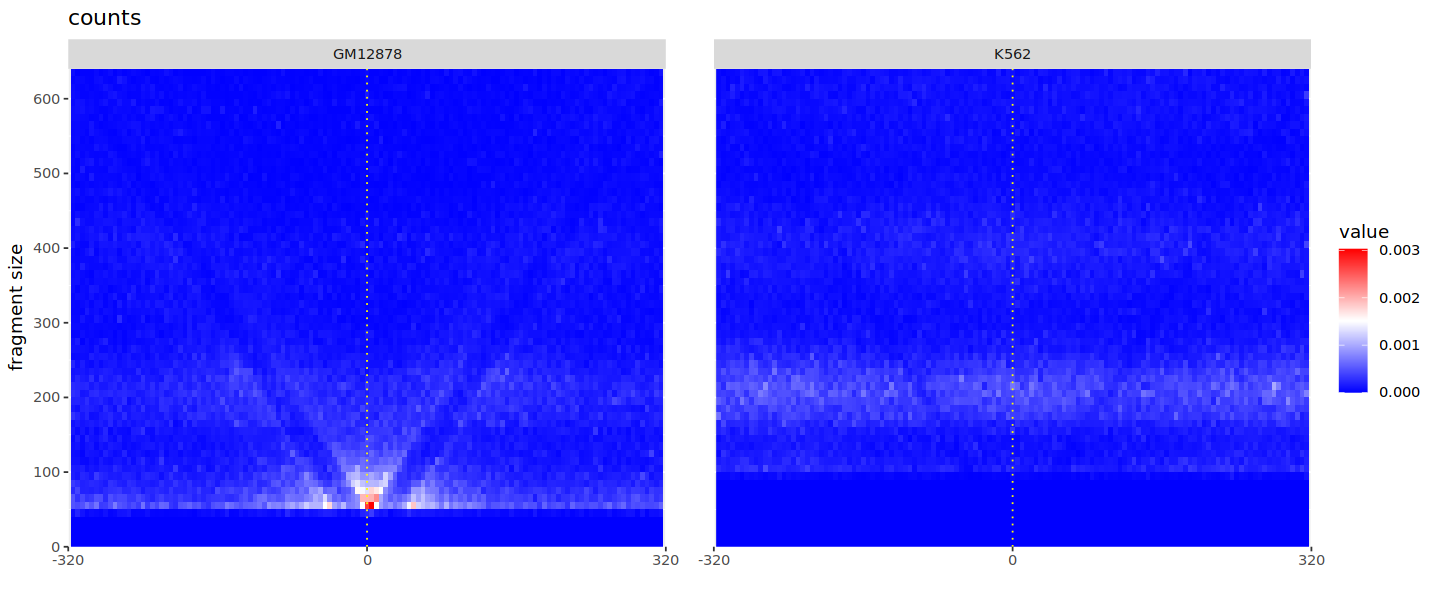

In [ ]:
vplot(x[nor])

In [ ]:
nfr <- res$pvalue_z < 0.05 & res$log_ratio < -0.2
sprintf('# regions become NFR in K562: %d', sum(nfr)) %>% message()

# regions become NFR in K562: 3125



Warning message:
"Removed 128 rows containing missing values (`geom_raster()`)."


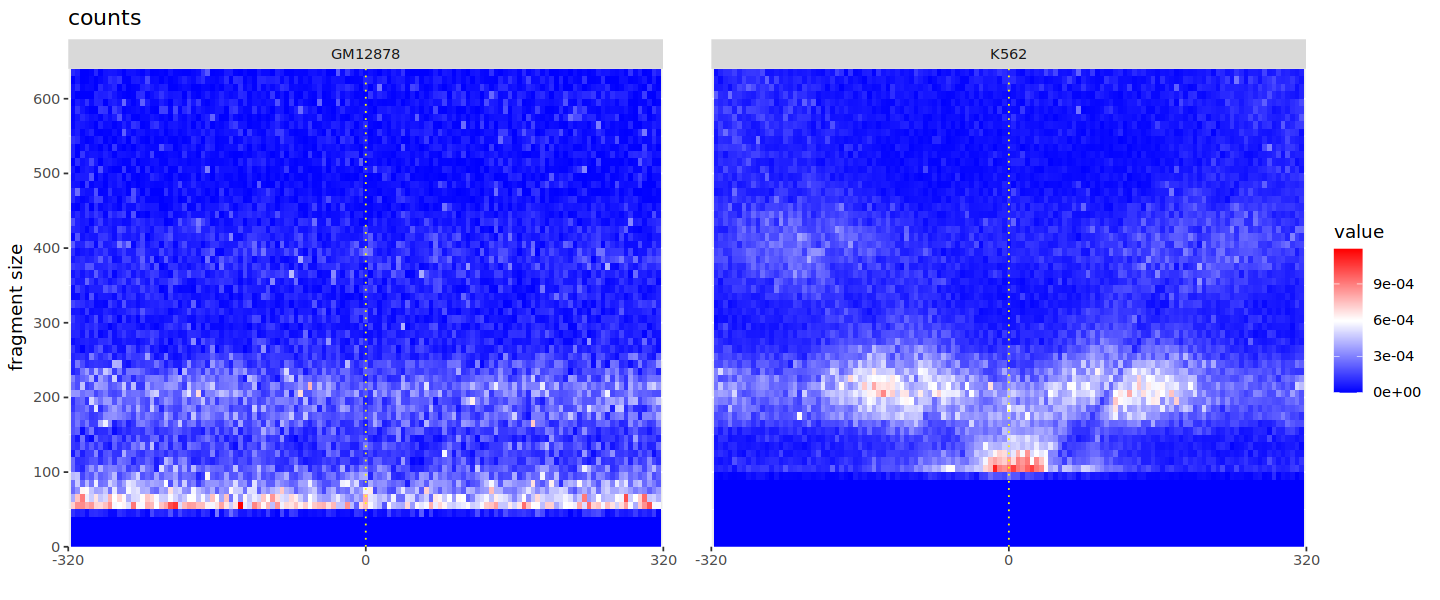

In [ ]:
vplot(x[nfr])

## Read bigwig

In [ ]:
histones <- c('H3K27ac', 'H3K4me1', 'H3K4me3')

In [ ]:
y <- NULL
for (i in names(ARGS$local_bw_files)){
  yi <- NULL
  for (j in histones){
    sprintf('reading %s', ARGS$local_bw_files[[i]][j]) %>% message()
    cvg <- rtracklayer::import(ARGS$local_bw_files[[i]][j], which = rowRanges(x))
    seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
    cvg <- coverage(cvg, weight = 'score')
    yij <- cvg[rowRanges(x)] %>% as.matrix() %>% tf$cast(tf$float32)
#    yij <- (yij - tf$reduce_min(yij, axis = 1L, keepdims = TRUE)) / (tf$reduce_max(yij, axis = 1L, keepdims = TRUE) - tf$reduce_min(yij, axis = 1L, keepdims = TRUE))
#    is_nan <- tf$math$is_nan(yij)
#    yij <- tf$where(is_nan, tf$zeros_like(is_nan, dtype = tf$float32), yij)
    yij <- tf$expand_dims(yij, axis = 1L)
    yij <- tf$expand_dims(yij, axis = 3L)
    yi <- c(yi, yij)
  }
  yi <- tf$concat(yi, axis = 3L)
  y <- c(y, yi)
}
y <- tf$concat(y, axis = 1L)

reading ./www.encodeproject.org/files/ENCFF440GZA/@@download/ENCFF440GZA.bigWig

reading ./www.encodeproject.org/files/ENCFF372EXQ/@@download/ENCFF372EXQ.bigWig

reading ./www.encodeproject.org/files/ENCFF154XCY/@@download/ENCFF154XCY.bigWig

reading ./www.encodeproject.org/files/ENCFF488FYZ/@@download/ENCFF488FYZ.bigWig

reading ./www.encodeproject.org/files/ENCFF700ZWZ/@@download/ENCFF700ZWZ.bigWig

reading ./www.encodeproject.org/files/ENCFF285EUA/@@download/ENCFF285EUA.bigWig



In [ ]:
y <- as.array(y)

In [ ]:
dimnames(y)[[2]] <- names(ARGS$remote_bam_files)
dimnames(y)[[4]] <- histones

In [ ]:
rowData(x)$histone <- y

## Read NucleoATAC data

In [ ]:
y <- NULL
for (i in names(ARGS$local_nucleoatac_files)){
  sprintf('reading %s', ARGS$local_nucleoatac_files[i]) %>% message()
  cvg <- rtracklayer::import(ARGS$local_nucleoatac_files[i], which = rowRanges(x))
  seqlengths(cvg) <- seqlengths(cvg) + ARGS$block_size
  cvg <- coverage(cvg, weight = 'score')
  yi <- cvg[rowRanges(x)] %>% as.matrix() %>% tf$cast(tf$float32)
#  yi <- (yi - tf$reduce_min(yi, axis = 1L, keepdims = TRUE)) / (tf$reduce_max(yi, axis = 1L, keepdims = TRUE) - tf$reduce_min(yi, axis = 1L, keepdims = TRUE))
#  is_nan <- tf$math$is_nan(yi)
#  yi <- tf$where(is_nan, tf$zeros_like(is_nan, dtype = tf$float32), yi)
  yi <- tf$expand_dims(yi, axis = 1L)
  y <- c(y, yi)
}
y <- tf$concat(y, axis = 1L)

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.nucleoatac_signal.smooth.bw

reading ./s3.msi.umn.edu/gongx030/datasets/dataset=K562_version=20230104a/K562.nucleoatac_signal.smooth.bw



In [ ]:
y <- as.array(y)

In [ ]:
dimnames(y)[[2]] <- names(ARGS$local_nucleoatac_files)

In [ ]:
rowData(x)$nucleoatac <- y

## Plot

In [ ]:
ga <- annotatePeak(gr)
is_promoter <- rowSums(ga@detailGenomicAnnotation[, c('Promoter', 'fiveUTR')]) > 0
is_distal <- rowSums(ga@detailGenomicAnnotation[, c('Intergenic', 'distal_intergenic')]) > 0

In [ ]:
df <- NULL
for (i in c('GM12878', 'K562')){
  for (h in histones){    
    y <- rowData(x)$histone[nfr & is_promoter & gr$label == 'NFKB1', i, , h] %>% colMeans()
    y <- (y - min(y)) / (max(y) - min(y))
    df <- rbind(df, data.frame(
      position = 1:ARGS$block_size - round(ARGS$block_size  / 2),
      signal = y,
      sample = i,
      histone = h,
      location = 'promoter',
      group = 'nfr'
    ))

    y <- rowData(x)$histone[nfr & is_distal& gr$label == 'NFKB1', i, , h] %>% colMeans()
    y <- (y - min(y)) / (max(y) - min(y))
    df <- rbind(df, data.frame(
      position = 1:ARGS$block_size - round(ARGS$block_size  / 2),
      signal = y,
      sample = i,
      histone = h,
      location = 'distal',
      group = 'nfr'
    ))
    
    y <- rowData(x)$histone[nor & is_promoter& gr$label == 'NFKB1', i, , h] %>% colMeans()
    y <- (y - min(y)) / (max(y) - min(y))
    df <- rbind(df, data.frame(
      position = 1:ARGS$block_size - round(ARGS$block_size  / 2),
      signal = y,
      sample = i,
      histone = h,
      location = 'promoter',
      group = 'nor'
    ))

    y <- rowData(x)$histone[nor & is_distal& gr$label == 'NFKB1', i, , h] %>% colMeans()
    y <- (y - min(y)) / (max(y) - min(y))
    df <- rbind(df, data.frame(
      position = 1:ARGS$block_size - round(ARGS$block_size  / 2),
      signal = y,
      sample = i,
      histone = h,
      location = 'distal',
      group = 'nor'
    ))
  }

  y <- rowData(x)$nucleoatac[nor & is_promoter& gr$label == 'NFKB1', i, ] %>% colMeans()
  y <- (y - min(y)) / (max(y) - min(y))
  df <- rbind(df, data.frame(
    position = 1:ARGS$block_size - round(ARGS$block_size  / 2),
    signal = y,
    sample = i,
    histone = 'nucleoatac',
    location = 'promoter',
    group = 'nor'
  ))

  y <- rowData(x)$nucleoatac[nor & is_distal& gr$label == 'NFKB1', i, ] %>% colMeans()
  y <- (y - min(y)) / (max(y) - min(y))
  df <- rbind(df, data.frame(
    position = 1:ARGS$block_size - round(ARGS$block_size  / 2),
    signal = y,
    sample = i,
    histone = 'nucleoatac',
    location = 'distal',
    group = 'nor'
  ))

}

Warning message:
"Removed 128 rows containing missing values (`geom_raster()`)."
# distal NFKB1 site NFR in GM12878: 1633/4966



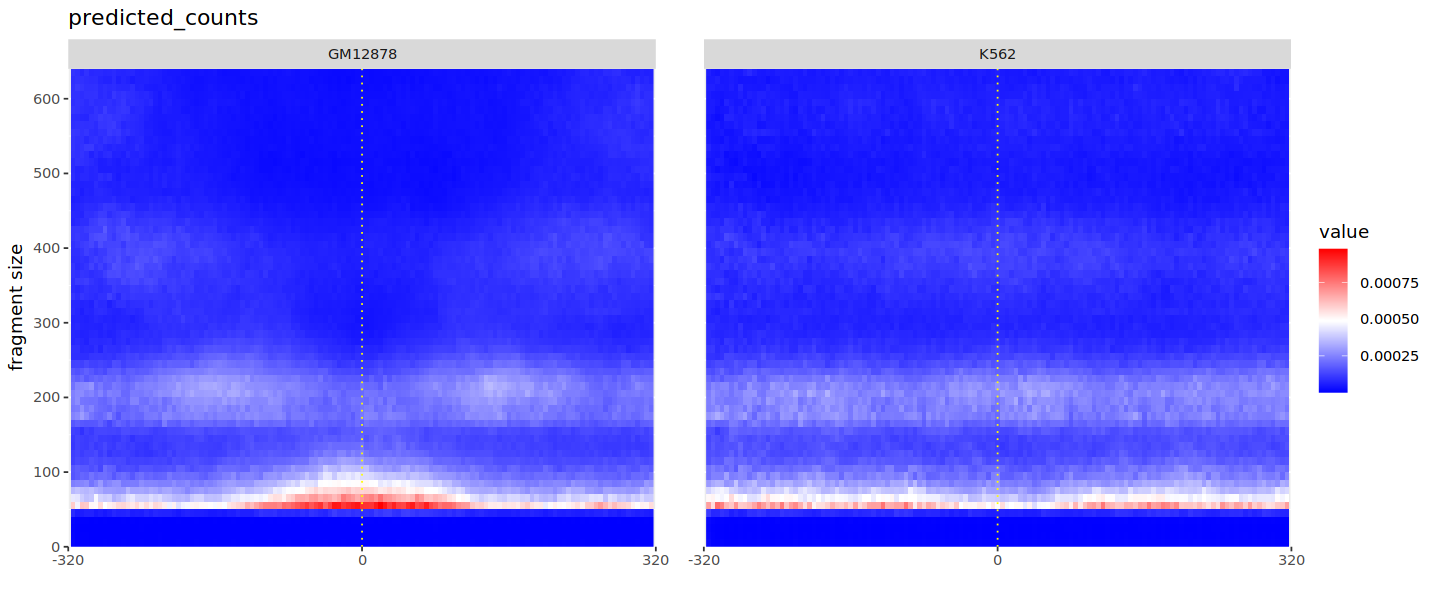

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 5)
i <- nor & gr$label == 'NFKB1' & is_distal
vplot(x[i], 'predicted_counts')
sprintf('# distal NFKB1 site NFR in GM12878: %d/%d', sum(i), sum(gr$label == 'NFKB1' & is_distal)) %>% message()

Warning message:
"Removed 128 rows containing missing values (`geom_raster()`)."
# promoter NFKB1 site NFR in GM12878: 728/2251



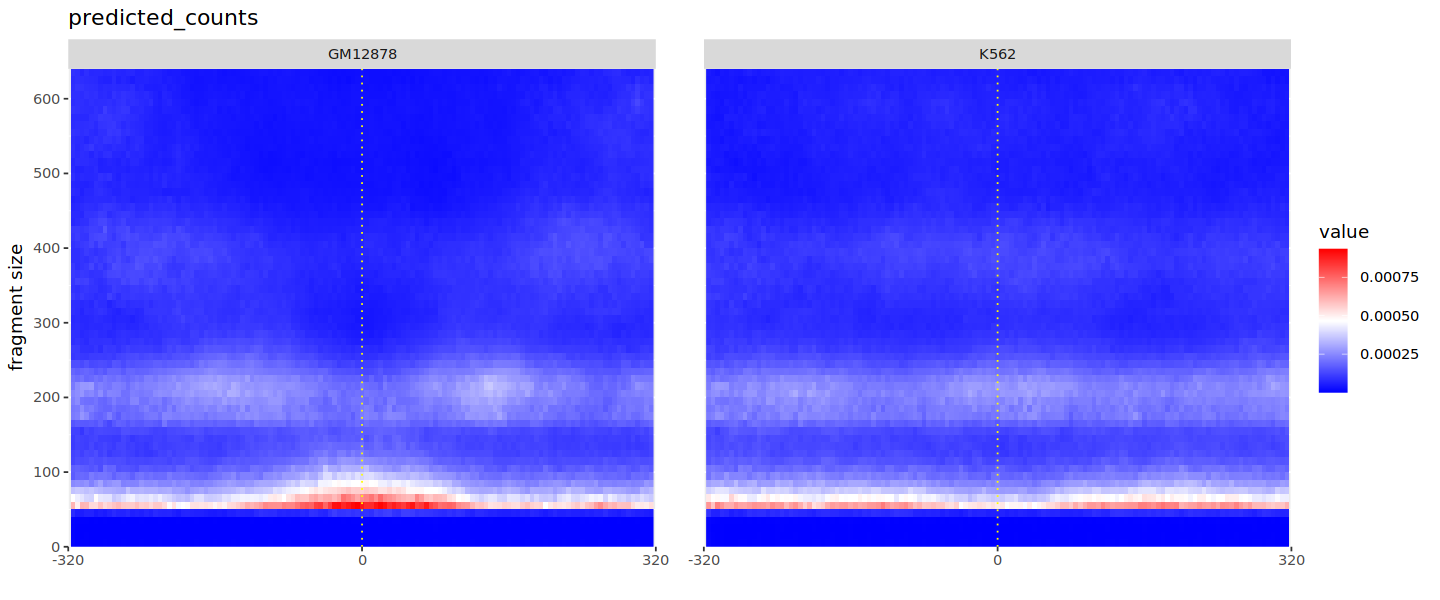

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 5)
i <- nor & gr$label == 'NFKB1' & is_promoter
vplot(x[i], 'predicted_counts')
sprintf('# promoter NFKB1 site NFR in GM12878: %d/%d', sum(i), sum(gr$label == 'NFKB1' & is_promoter)) %>% message()

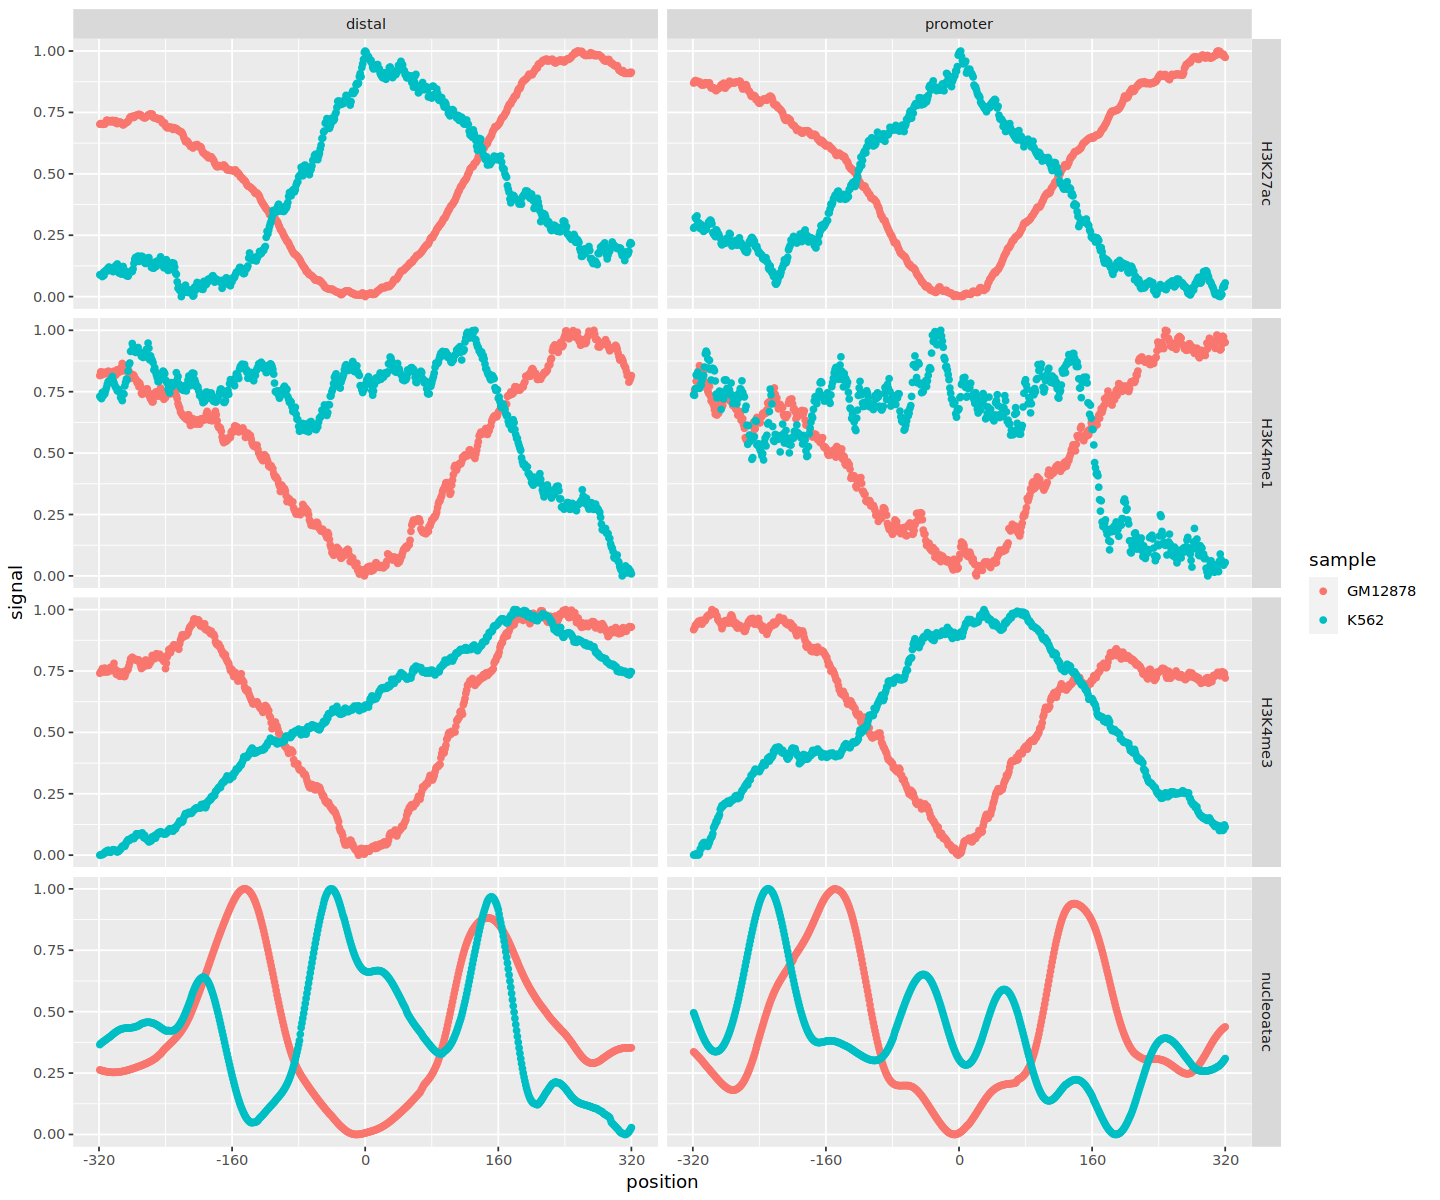

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 10)
df %>%
  dplyr::filter(group == 'nor') %>%
  ggplot(aes(x = position, y = signal, color = sample)) + 
  geom_point() +
  facet_grid(histone ~ location) +
  scale_x_continuous(breaks = c(-320, -160, 0, 160, 320))

## SessionInfo

In [ ]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /panfs/jay/groups/18/garrydj/gongx030/.conda/envs/r421_py37_tf26/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg19_1.4.3        
 [2] BSgenome.Mmusculus.UCSC.mm10_1.4.3       
 [3] BSgenome_1.64.0                          
 [4] rtracklayer_1.56.1                       
 [5] Biostrings_2.64.1                        
 [6] XVector_0.36.0    